In [89]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
from tensorflow.keras import backend as K
from tensorflow.keras.backend import argmax, cast
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Embedding, RepeatVector, Reshape, Conv1D, MaxPooling1D, UpSampling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [90]:
minor_df = pd.read_csv("Datasets/bassline_representations_min.csv", header=None)
major_df = pd.read_csv("Datasets/bassline_representations_maj.csv", header=None)

In [91]:
minor_df.shape, major_df.shape

((208, 64), (69, 64))

In [92]:
all_data = pd.concat((minor_df, major_df))
minor_data = minor_df.values
major_data = major_df.values

In [93]:
notes = np.unique(all_data)
vocab = np.arange(len(notes))

n2v_mapping = dict(zip(notes, vocab))
v2n_mapping = dict(zip(vocab, notes))

vocab_size = len(n2v_mapping)

def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    # Drop the magic bomb with searchsorted to get the corresponding
    # places for a in keys (using sorter since a is not necessarily sorted).
    # Then trace it back to original order with indexing into sidx
    # Finally index into values for desired output.
    return v[sidx[np.searchsorted(k,ar,sorter=sidx)]]

minor_data = replace_with_dict(minor_data, n2v_mapping).astype(int)
major_data = replace_with_dict(major_data, n2v_mapping).astype(int)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(minor_data, minor_data, test_size=0.2, random_state=42)

In [95]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]

In [96]:
#def replace_continue(arr, cont_token):
#    for r in arr:
#        for idx, el in enumerate(r[1:]):
#            if el == cont_token:
#                r[idx + 1] = r[idx]
#
#cont_token = 35
#
#
#replace_continue(X_train, cont_token)
#replace_continue(y_train, cont_token)
#replace_continue(X_test, cont_token)
#replace_continue(y_test, cont_token)

In [97]:
def one_hot_encode(arr, encode_length):
    return np.eye(encode_length)[arr.astype(np.uint)]

In [98]:
y_train = one_hot_encode(y_train, vocab_size)
y_test = one_hot_encode(y_test, vocab_size)

## Model 1

In [11]:
timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
#encoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(embedded)
encoded = LSTM(latent_dim, dropout=dropout)(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [12]:
sequence_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1152      
_________________________________________________________________
lstm (LSTM)                  (None, 256)               295936    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 64, 36)            9252      
Total params: 831,652
Trainable params: 831,652
Non-trainable params: 0
_______________________________________________________

In [13]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [14]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1152      
_________________________________________________________________
lstm (LSTM)                  (None, 256)               295936    
Total params: 297,088
Trainable params: 297,088
Non-trainable params: 0
_________________________________________________________________


In [15]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 64, 36)            9252      
Total params: 534,564
Trainable params: 534,564
Non-trainable params: 0
_________________________________________________________________


In [16]:
lr = 5e-3

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, mode='min')
mc = ModelCheckpoint('NBG_lstm.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [17]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/500
6/6 [==============================] - 10s 866ms/step - loss: 3.4393 - val_loss: 2.4403
Epoch 2/500
6/6 [==============================] - 0s 39ms/step - loss: 2.2420 - val_loss: 1.9641
Epoch 3/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0618 - val_loss: 1.9460
Epoch 4/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0324 - val_loss: 1.9317
Epoch 5/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0291 - val_loss: 1.9273
Epoch 6/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0103 - val_loss: 1.9162
Epoch 7/500
6/6 [==============================] - 0s 37ms/step - loss: 2.0154 - val_loss: 1.9079
Epoch 8/500
6/6 [==============================] - 0s 36ms/step - loss: 1.9934 - val_loss: 1.9065
Epoch 9/500
6/6 [==============================] - 0s 36ms/step - loss: 1.9968 - val_loss: 1.9066
Epoch 10/500
6/6 [==============================] - 0s 38ms/step - loss: 1.9787 - val_loss: 1.9052
Epoch 11/500
6/6 

Epoch 84/500
6/6 [==============================] - 0s 37ms/step - loss: 1.4454 - val_loss: 1.8348
Epoch 85/500
6/6 [==============================] - 0s 32ms/step - loss: 1.4332 - val_loss: 1.8318
Epoch 86/500
6/6 [==============================] - 0s 32ms/step - loss: 1.4196 - val_loss: 1.8515
Epoch 87/500
6/6 [==============================] - 0s 38ms/step - loss: 1.4223 - val_loss: 1.8560
Epoch 88/500
6/6 [==============================] - 0s 37ms/step - loss: 1.3889 - val_loss: 1.8559
Epoch 89/500
6/6 [==============================] - 0s 33ms/step - loss: 1.4102 - val_loss: 1.8722
Epoch 90/500
6/6 [==============================] - 0s 31ms/step - loss: 1.3843 - val_loss: 1.8741
Epoch 91/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4106 - val_loss: 1.8726
Epoch 92/500
6/6 [==============================] - 0s 32ms/step - loss: 1.4098 - val_loss: 1.8825
Epoch 93/500
6/6 [==============================] - 0s 37ms/step - loss: 1.4076 - val_loss: 1.8915
Epoch 94/5

6/6 [==============================] - 0s 38ms/step - loss: 1.1957 - val_loss: 2.0824
Epoch 167/500
6/6 [==============================] - 0s 35ms/step - loss: 1.2014 - val_loss: 2.0904
Epoch 168/500
6/6 [==============================] - 0s 33ms/step - loss: 1.2053 - val_loss: 2.0997
Epoch 169/500
6/6 [==============================] - 0s 35ms/step - loss: 1.1913 - val_loss: 2.0843
Epoch 170/500
6/6 [==============================] - 0s 38ms/step - loss: 1.1988 - val_loss: 2.1151
Epoch 171/500
6/6 [==============================] - 0s 37ms/step - loss: 1.1926 - val_loss: 2.1177
Epoch 172/500
6/6 [==============================] - 0s 38ms/step - loss: 1.1796 - val_loss: 2.1365
Epoch 173/500
6/6 [==============================] - 0s 65ms/step - loss: 1.1885 - val_loss: 2.1354
Epoch 174/500
6/6 [==============================] - 0s 33ms/step - loss: 1.1722 - val_loss: 2.1458
Epoch 175/500
6/6 [==============================] - 0s 31ms/step - loss: 1.1548 - val_loss: 2.1467
Epoch 176/500


6/6 [==============================] - 0s 40ms/step - loss: 1.0230 - val_loss: 2.3302
Epoch 249/500
6/6 [==============================] - 0s 36ms/step - loss: 1.0858 - val_loss: 2.1850
Epoch 250/500
6/6 [==============================] - 0s 36ms/step - loss: 1.0899 - val_loss: 2.2169
Epoch 251/500
6/6 [==============================] - 0s 34ms/step - loss: 1.0877 - val_loss: 2.2029
Epoch 252/500
6/6 [==============================] - 0s 39ms/step - loss: 1.0512 - val_loss: 2.2362
Epoch 253/500
6/6 [==============================] - 0s 34ms/step - loss: 1.0599 - val_loss: 2.3060
Epoch 254/500
6/6 [==============================] - 0s 34ms/step - loss: 1.0317 - val_loss: 2.2505
Epoch 255/500
6/6 [==============================] - 0s 33ms/step - loss: 1.0178 - val_loss: 2.2580
Epoch 256/500
6/6 [==============================] - 0s 35ms/step - loss: 1.0504 - val_loss: 2.2143
Epoch 257/500
6/6 [==============================] - 0s 33ms/step - loss: 1.0354 - val_loss: 2.2432
Epoch 258/500


6/6 [==============================] - 0s 36ms/step - loss: 0.7609 - val_loss: 2.7007
Epoch 331/500
6/6 [==============================] - 0s 36ms/step - loss: 0.7722 - val_loss: 2.6960
Epoch 332/500
6/6 [==============================] - 0s 34ms/step - loss: 0.7673 - val_loss: 2.6895
Epoch 333/500
6/6 [==============================] - 0s 34ms/step - loss: 0.7738 - val_loss: 2.7286
Epoch 334/500
6/6 [==============================] - 0s 37ms/step - loss: 0.7760 - val_loss: 2.7631
Epoch 335/500
6/6 [==============================] - 0s 33ms/step - loss: 0.7697 - val_loss: 2.7396
Epoch 336/500
6/6 [==============================] - 0s 33ms/step - loss: 0.7683 - val_loss: 2.7558
Epoch 337/500
6/6 [==============================] - 0s 33ms/step - loss: 0.7466 - val_loss: 2.7637
Epoch 338/500
6/6 [==============================] - 0s 31ms/step - loss: 0.8191 - val_loss: 2.5875
Epoch 339/500
6/6 [==============================] - 0s 30ms/step - loss: 0.9680 - val_loss: 2.5579
Epoch 340/500


6/6 [==============================] - 0s 32ms/step - loss: 0.9105 - val_loss: 2.3986
Epoch 413/500
6/6 [==============================] - 0s 34ms/step - loss: 0.9078 - val_loss: 2.4094
Epoch 414/500
6/6 [==============================] - 0s 31ms/step - loss: 0.8751 - val_loss: 2.4029
Epoch 415/500
6/6 [==============================] - 0s 32ms/step - loss: 0.8680 - val_loss: 2.3798
Epoch 416/500
6/6 [==============================] - 0s 31ms/step - loss: 0.8396 - val_loss: 2.4105
Epoch 417/500
6/6 [==============================] - 0s 33ms/step - loss: 0.8310 - val_loss: 2.4303
Epoch 418/500
6/6 [==============================] - 0s 31ms/step - loss: 0.8000 - val_loss: 2.4561
Epoch 419/500
6/6 [==============================] - 0s 32ms/step - loss: 0.7750 - val_loss: 2.4946
Epoch 420/500
6/6 [==============================] - 0s 32ms/step - loss: 0.7551 - val_loss: 2.5143
Epoch 421/500
6/6 [==============================] - 0s 33ms/step - loss: 0.7332 - val_loss: 2.5237
Epoch 422/500


6/6 [==============================] - 0s 37ms/step - loss: 0.6776 - val_loss: 2.9148
Epoch 495/500
6/6 [==============================] - 0s 35ms/step - loss: 0.8892 - val_loss: 2.8561
Epoch 496/500
6/6 [==============================] - 0s 37ms/step - loss: 0.9307 - val_loss: 2.7095
Epoch 497/500
6/6 [==============================] - 0s 39ms/step - loss: 0.9725 - val_loss: 2.7209
Epoch 498/500
6/6 [==============================] - 0s 69ms/step - loss: 0.9293 - val_loss: 2.7285
Epoch 499/500
6/6 [==============================] - 0s 32ms/step - loss: 0.8591 - val_loss: 2.6945
Epoch 500/500
6/6 [==============================] - 0s 35ms/step - loss: 0.7948 - val_loss: 2.7062


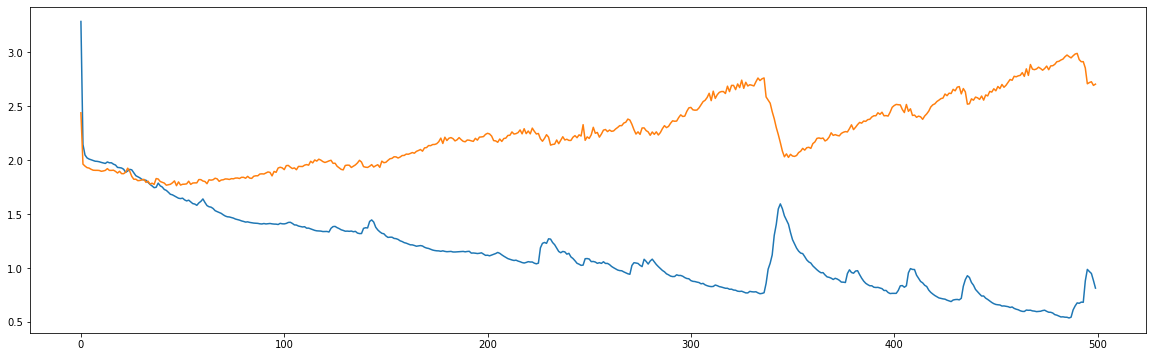

In [19]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [20]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.6987010542168675

## Model 2

In [135]:
timesteps = 64  # Length of your sequences
embed_size = 16
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
encoded = Bidirectional(LSTM(latent_dim, return_sequences=True, dropout=dropout))(embedded)
encoded = Bidirectional(LSTM(latent_dim, dropout=dropout))(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [136]:
sequence_autoencoder.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 64, 16)            576       
_________________________________________________________________
bidirectional_9 (Bidirection (None, 512)               559104    
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 64, 512)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 64, 256)           787456    
_________________________________________________________________
dense_9 (Dense)              (None, 64, 36)            9252      
Total params: 1,356,388
Trainable params: 1,356,388
Non-trainable params: 0
________________________________________________

In [139]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(2*latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [140]:
encoder.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 64, 16)            576       
_________________________________________________________________
bidirectional_9 (Bidirection (None, 512)               559104    
Total params: 559,680
Trainable params: 559,680
Non-trainable params: 0
_________________________________________________________________


In [141]:
decoder.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 64, 512)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 64, 256)           787456    
_________________________________________________________________
dense_9 (Dense)              (None, 64, 36)            9252      
Total params: 796,708
Trainable params: 796,708
Non-trainable params: 0
_________________________________________________________________


In [142]:
lr = 5e-3

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, mode='min')
mc = ModelCheckpoint('NBG_bilstm_stacked.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [143]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/200
6/6 [==============================] - 6s 317ms/step - loss: 3.2073 - val_loss: 2.0711
Epoch 2/200
6/6 [==============================] - 0s 43ms/step - loss: 2.1104 - val_loss: 2.0089
Epoch 3/200
6/6 [==============================] - 0s 43ms/step - loss: 2.0446 - val_loss: 1.9283
Epoch 4/200
6/6 [==============================] - 0s 39ms/step - loss: 2.0187 - val_loss: 1.9311
Epoch 5/200
6/6 [==============================] - 0s 41ms/step - loss: 1.9818 - val_loss: 1.9245
Epoch 6/200
6/6 [==============================] - 0s 40ms/step - loss: 2.0272 - val_loss: 1.9168
Epoch 7/200
6/6 [==============================] - 0s 37ms/step - loss: 2.0090 - val_loss: 1.9068
Epoch 8/200
6/6 [==============================] - 0s 39ms/step - loss: 1.9667 - val_loss: 1.9128
Epoch 9/200
6/6 [==============================] - 0s 39ms/step - loss: 1.9876 - val_loss: 1.9033
Epoch 10/200
6/6 [==============================] - 0s 37ms/step - loss: 1.9989 - val_loss: 1.8998
Epoch 11/200
6/6 [

Epoch 84/200
6/6 [==============================] - 0s 36ms/step - loss: 1.4231 - val_loss: 1.8210
Epoch 85/200
6/6 [==============================] - 0s 36ms/step - loss: 1.4457 - val_loss: 1.8316
Epoch 86/200
6/6 [==============================] - 0s 34ms/step - loss: 1.4250 - val_loss: 1.8241
Epoch 87/200
6/6 [==============================] - 0s 34ms/step - loss: 1.4340 - val_loss: 1.8476
Epoch 88/200
6/6 [==============================] - 0s 40ms/step - loss: 1.4139 - val_loss: 1.8112
Epoch 89/200
6/6 [==============================] - 0s 37ms/step - loss: 1.4127 - val_loss: 1.8292
Epoch 90/200
6/6 [==============================] - 0s 37ms/step - loss: 1.4096 - val_loss: 1.8243
Epoch 91/200
6/6 [==============================] - 0s 41ms/step - loss: 1.3868 - val_loss: 1.8512
Epoch 92/200
6/6 [==============================] - 0s 41ms/step - loss: 1.3714 - val_loss: 1.8356
Epoch 93/200
6/6 [==============================] - 0s 41ms/step - loss: 1.3880 - val_loss: 1.8523
Epoch 94/2

6/6 [==============================] - 0s 38ms/step - loss: 1.2468 - val_loss: 1.9391
Epoch 167/200
6/6 [==============================] - 0s 41ms/step - loss: 1.2787 - val_loss: 1.9620
Epoch 168/200
6/6 [==============================] - 0s 40ms/step - loss: 1.2455 - val_loss: 2.0148
Epoch 169/200
6/6 [==============================] - 0s 38ms/step - loss: 1.2750 - val_loss: 2.0037
Epoch 170/200
6/6 [==============================] - 0s 35ms/step - loss: 1.2936 - val_loss: 1.9945
Epoch 171/200
6/6 [==============================] - 0s 37ms/step - loss: 1.2698 - val_loss: 1.9696
Epoch 172/200
6/6 [==============================] - 0s 39ms/step - loss: 1.2627 - val_loss: 1.9947
Epoch 173/200
6/6 [==============================] - 0s 41ms/step - loss: 1.2248 - val_loss: 1.9615
Epoch 174/200
6/6 [==============================] - 0s 48ms/step - loss: 1.2624 - val_loss: 1.9689
Epoch 175/200
6/6 [==============================] - 0s 47ms/step - loss: 1.2498 - val_loss: 1.9486
Epoch 176/200


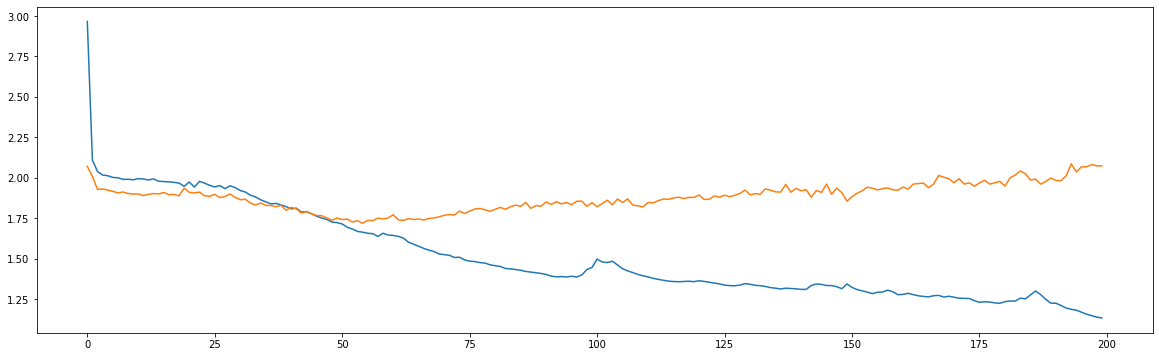

In [144]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [145]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.5833960843373494

## Model 3

In [21]:
timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
#encoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(embedded)
encoded = GRU(latent_dim, dropout=dropout)(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = GRU(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [22]:
sequence_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 256)           394752    
_________________________________________________________________
dense_1 (Dense)              (None, 64, 36)            9252      
Total params: 627,876
Trainable params: 627,876
Non-trainable params: 0
_____________________________________________________

In [23]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [24]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
Total params: 223,872
Trainable params: 223,872
Non-trainable params: 0
_________________________________________________________________


In [25]:
decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 256)           394752    
_________________________________________________________________
dense_1 (Dense)              (None, 64, 36)            9252      
Total params: 404,004
Trainable params: 404,004
Non-trainable params: 0
_________________________________________________________________


In [26]:
lr = 5e-3

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, mode='min')
mc = ModelCheckpoint('NBG_gru.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [27]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/500
6/6 [==============================] - 3s 243ms/step - loss: 3.5738 - val_loss: 2.2239
Epoch 2/500
6/6 [==============================] - 0s 32ms/step - loss: 2.4335 - val_loss: 2.2289
Epoch 3/500
6/6 [==============================] - 0s 31ms/step - loss: 2.2048 - val_loss: 2.0103
Epoch 4/500
6/6 [==============================] - 0s 31ms/step - loss: 2.0798 - val_loss: 1.9508
Epoch 5/500
6/6 [==============================] - 0s 31ms/step - loss: 2.0281 - val_loss: 1.9307
Epoch 6/500
6/6 [==============================] - 0s 34ms/step - loss: 2.0101 - val_loss: 1.9313
Epoch 7/500
6/6 [==============================] - 0s 36ms/step - loss: 1.9478 - val_loss: 1.9086
Epoch 8/500
6/6 [==============================] - 0s 35ms/step - loss: 1.9353 - val_loss: 1.8944
Epoch 9/500
6/6 [==============================] - 0s 39ms/step - loss: 1.9578 - val_loss: 1.8687
Epoch 10/500
6/6 [==============================] - 0s 35ms/step - loss: 1.8986 - val_loss: 1.7943
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 34ms/step - loss: 1.4159 - val_loss: 1.7005
Epoch 85/500
6/6 [==============================] - 0s 36ms/step - loss: 1.3815 - val_loss: 1.7205
Epoch 86/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4061 - val_loss: 1.7181
Epoch 87/500
6/6 [==============================] - 0s 33ms/step - loss: 1.4177 - val_loss: 1.7303
Epoch 88/500
6/6 [==============================] - 0s 35ms/step - loss: 1.4257 - val_loss: 1.7252
Epoch 89/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4037 - val_loss: 1.7316
Epoch 90/500
6/6 [==============================] - 0s 35ms/step - loss: 1.3883 - val_loss: 1.7477
Epoch 91/500
6/6 [==============================] - 0s 33ms/step - loss: 1.4169 - val_loss: 1.7499
Epoch 92/500
6/6 [==============================] - 0s 35ms/step - loss: 1.4225 - val_loss: 1.7126
Epoch 93/500
6/6 [==============================] - 0s 36ms/step - loss: 1.3957 - val_loss: 1.7386
Epoch 94/5

6/6 [==============================] - 0s 35ms/step - loss: 1.5096 - val_loss: 1.7112
Epoch 167/500
6/6 [==============================] - 0s 34ms/step - loss: 1.5141 - val_loss: 1.7297
Epoch 168/500
6/6 [==============================] - 0s 33ms/step - loss: 1.4834 - val_loss: 1.7474
Epoch 169/500
6/6 [==============================] - 0s 34ms/step - loss: 1.4781 - val_loss: 1.7308
Epoch 170/500
6/6 [==============================] - 0s 35ms/step - loss: 1.5126 - val_loss: 1.7406
Epoch 171/500
6/6 [==============================] - 0s 36ms/step - loss: 1.5239 - val_loss: 1.7309
Epoch 172/500
6/6 [==============================] - 0s 34ms/step - loss: 1.4633 - val_loss: 1.7322
Epoch 173/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4444 - val_loss: 1.7497
Epoch 174/500
6/6 [==============================] - 0s 34ms/step - loss: 1.4196 - val_loss: 1.7478
Epoch 175/500
6/6 [==============================] - 0s 34ms/step - loss: 1.4206 - val_loss: 1.7531
Epoch 176/500


6/6 [==============================] - 0s 32ms/step - loss: 1.3964 - val_loss: 1.8397
Epoch 249/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4577 - val_loss: 1.8503
Epoch 250/500
6/6 [==============================] - 0s 33ms/step - loss: 1.4278 - val_loss: 1.8971
Epoch 251/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4798 - val_loss: 1.8717
Epoch 252/500
6/6 [==============================] - 0s 35ms/step - loss: 1.4398 - val_loss: 1.9285
Epoch 253/500
6/6 [==============================] - 0s 35ms/step - loss: 1.4445 - val_loss: 1.8280
Epoch 254/500
6/6 [==============================] - 0s 32ms/step - loss: 1.3773 - val_loss: 1.8957
Epoch 255/500
6/6 [==============================] - 0s 33ms/step - loss: 1.3876 - val_loss: 1.8880
Epoch 256/500
6/6 [==============================] - 0s 33ms/step - loss: 1.3604 - val_loss: 1.8613
Epoch 257/500
6/6 [==============================] - 0s 41ms/step - loss: 1.4016 - val_loss: 1.8557
Epoch 258/500


6/6 [==============================] - 0s 35ms/step - loss: 1.2037 - val_loss: 1.8111
Epoch 331/500
6/6 [==============================] - 0s 34ms/step - loss: 1.2242 - val_loss: 1.8356
Epoch 332/500
6/6 [==============================] - 0s 34ms/step - loss: 1.2238 - val_loss: 1.8392
Epoch 333/500
6/6 [==============================] - 0s 36ms/step - loss: 1.2423 - val_loss: 1.8622
Epoch 334/500
6/6 [==============================] - 0s 32ms/step - loss: 1.2335 - val_loss: 1.8363
Epoch 335/500
6/6 [==============================] - 0s 36ms/step - loss: 1.2224 - val_loss: 1.8661
Epoch 336/500
6/6 [==============================] - 0s 71ms/step - loss: 1.2446 - val_loss: 1.8395
Epoch 337/500
6/6 [==============================] - 0s 33ms/step - loss: 1.2999 - val_loss: 1.8822
Epoch 338/500
6/6 [==============================] - 0s 35ms/step - loss: 1.3205 - val_loss: 1.8338
Epoch 339/500
6/6 [==============================] - 0s 35ms/step - loss: 1.2504 - val_loss: 1.8846
Epoch 340/500


6/6 [==============================] - 0s 33ms/step - loss: 1.5580 - val_loss: 1.7689
Epoch 413/500
6/6 [==============================] - 0s 33ms/step - loss: 1.5316 - val_loss: 1.7511
Epoch 414/500
6/6 [==============================] - 0s 33ms/step - loss: 1.5219 - val_loss: 1.7545
Epoch 415/500
6/6 [==============================] - 0s 33ms/step - loss: 1.5361 - val_loss: 1.7535
Epoch 416/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4900 - val_loss: 1.7599
Epoch 417/500
6/6 [==============================] - 0s 32ms/step - loss: 1.5026 - val_loss: 1.7628
Epoch 418/500
6/6 [==============================] - 0s 32ms/step - loss: 1.4929 - val_loss: 1.7575
Epoch 419/500
6/6 [==============================] - 0s 38ms/step - loss: 1.4852 - val_loss: 1.7521
Epoch 420/500
6/6 [==============================] - 0s 35ms/step - loss: 1.4613 - val_loss: 1.7704
Epoch 421/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4732 - val_loss: 1.7596
Epoch 422/500


6/6 [==============================] - 0s 34ms/step - loss: 1.3395 - val_loss: 1.9122
Epoch 495/500
6/6 [==============================] - 0s 35ms/step - loss: 1.3230 - val_loss: 1.9146
Epoch 496/500
6/6 [==============================] - 0s 33ms/step - loss: 1.3140 - val_loss: 1.9076
Epoch 497/500
6/6 [==============================] - 0s 34ms/step - loss: 1.3289 - val_loss: 1.9131
Epoch 498/500
6/6 [==============================] - 0s 36ms/step - loss: 1.3342 - val_loss: 1.9136
Epoch 499/500
6/6 [==============================] - 0s 35ms/step - loss: 1.3166 - val_loss: 1.9073
Epoch 500/500
6/6 [==============================] - 0s 33ms/step - loss: 1.3205 - val_loss: 1.9132


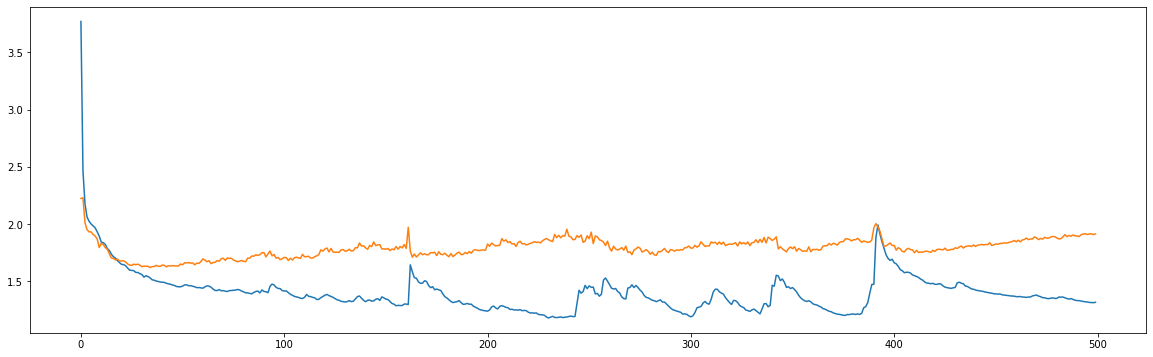

In [28]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [29]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.5212725903614458

## Model 4

In [30]:
timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
encoded = Conv1D(latent_dim, 3, activation='relu', padding='same')(embedded)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(2 * latent_dim, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)

decoded = Conv1D(2 * latent_dim, 3, activation='relu', padding='same')(encoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(latent_dim, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(1, 3, activation='relu', padding='same')(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [31]:
sequence_autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           24832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 512)           393728    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 512)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 512)           7869

In [32]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(timesteps//4,2*latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-6:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [33]:
encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           24832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 512)           393728    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 512)           0         
Total params: 419,712
Trainable params: 419,712
Non-trainable params: 0
_____________________________________________________

In [34]:
decoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 16, 512)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 512)           786944    
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 32, 512)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 256)           393472    
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 64, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 1)             769       
_________________________________________________________________
dense_2 (Dense)              (None, 64, 36)            72  

In [35]:
lr = 5e-3

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, mode='min')
mc = ModelCheckpoint('NBG_conv.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [36]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/500
6/6 [==============================] - 3s 205ms/step - loss: 3.5610 - val_loss: 3.5031
Epoch 2/500
6/6 [==============================] - 0s 26ms/step - loss: 3.4538 - val_loss: 3.2767
Epoch 3/500
6/6 [==============================] - 0s 25ms/step - loss: 3.2578 - val_loss: 3.0783
Epoch 4/500
6/6 [==============================] - 0s 26ms/step - loss: 3.0496 - val_loss: 2.8045
Epoch 5/500
6/6 [==============================] - 0s 24ms/step - loss: 2.7807 - val_loss: 2.4596
Epoch 6/500
6/6 [==============================] - 0s 23ms/step - loss: 2.4478 - val_loss: 2.1525
Epoch 7/500
6/6 [==============================] - 0s 26ms/step - loss: 2.1906 - val_loss: 2.0110
Epoch 8/500
6/6 [==============================] - 0s 28ms/step - loss: 2.0498 - val_loss: 1.9340
Epoch 9/500
6/6 [==============================] - 0s 31ms/step - loss: 2.0035 - val_loss: 1.8899
Epoch 10/500
6/6 [==============================] - 0s 32ms/step - loss: 1.9518 - val_loss: 1.8527
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 33ms/step - loss: 1.1832 - val_loss: 1.2739
Epoch 85/500
6/6 [==============================] - 0s 29ms/step - loss: 1.2011 - val_loss: 1.2817
Epoch 86/500
6/6 [==============================] - 0s 34ms/step - loss: 1.2142 - val_loss: 1.2753
Epoch 87/500
6/6 [==============================] - 0s 31ms/step - loss: 1.2187 - val_loss: 1.2782
Epoch 88/500
6/6 [==============================] - 0s 34ms/step - loss: 1.1962 - val_loss: 1.2855
Epoch 89/500
6/6 [==============================] - 0s 37ms/step - loss: 1.1885 - val_loss: 1.3300
Epoch 90/500
6/6 [==============================] - 0s 34ms/step - loss: 1.1846 - val_loss: 1.2840
Epoch 91/500
6/6 [==============================] - 0s 33ms/step - loss: 1.1541 - val_loss: 1.2722
Epoch 92/500
6/6 [==============================] - 0s 38ms/step - loss: 1.1817 - val_loss: 1.2856
Epoch 93/500
6/6 [==============================] - 0s 36ms/step - loss: 1.1625 - val_loss: 1.2638
Epoch 94/5

6/6 [==============================] - 0s 30ms/step - loss: 1.0150 - val_loss: 1.2626
Epoch 167/500
6/6 [==============================] - 0s 29ms/step - loss: 1.0889 - val_loss: 1.2790
Epoch 168/500
6/6 [==============================] - 0s 28ms/step - loss: 1.0853 - val_loss: 1.2505
Epoch 169/500
6/6 [==============================] - 0s 31ms/step - loss: 1.0576 - val_loss: 1.2689
Epoch 170/500
6/6 [==============================] - 0s 29ms/step - loss: 1.0425 - val_loss: 1.2839
Epoch 171/500
6/6 [==============================] - 0s 28ms/step - loss: 1.0349 - val_loss: 1.3088
Epoch 172/500
6/6 [==============================] - 0s 30ms/step - loss: 1.0495 - val_loss: 1.2389
Epoch 173/500
6/6 [==============================] - 0s 30ms/step - loss: 1.0607 - val_loss: 1.2906
Epoch 174/500
6/6 [==============================] - 0s 32ms/step - loss: 1.0711 - val_loss: 1.1963
Epoch 175/500
6/6 [==============================] - 0s 30ms/step - loss: 1.0654 - val_loss: 1.2183
Epoch 176/500


6/6 [==============================] - 0s 31ms/step - loss: 1.0212 - val_loss: 1.3138
Epoch 249/500
6/6 [==============================] - 0s 33ms/step - loss: 0.9839 - val_loss: 1.3058
Epoch 250/500
6/6 [==============================] - 0s 34ms/step - loss: 0.9729 - val_loss: 1.2708
Epoch 251/500
6/6 [==============================] - 0s 31ms/step - loss: 0.9876 - val_loss: 1.3126
Epoch 252/500
6/6 [==============================] - 0s 33ms/step - loss: 0.9793 - val_loss: 1.3317
Epoch 253/500
6/6 [==============================] - 0s 36ms/step - loss: 0.9766 - val_loss: 1.3161
Epoch 254/500
6/6 [==============================] - 0s 30ms/step - loss: 0.9915 - val_loss: 1.3314
Epoch 255/500
6/6 [==============================] - 0s 32ms/step - loss: 0.9972 - val_loss: 1.4310
Epoch 256/500
6/6 [==============================] - 0s 31ms/step - loss: 0.9848 - val_loss: 1.4208
Epoch 257/500
6/6 [==============================] - 0s 35ms/step - loss: 1.0172 - val_loss: 1.3335
Epoch 258/500


6/6 [==============================] - 0s 27ms/step - loss: 0.9269 - val_loss: 1.4062
Epoch 331/500
6/6 [==============================] - 0s 34ms/step - loss: 0.9124 - val_loss: 1.3836
Epoch 332/500
6/6 [==============================] - 0s 36ms/step - loss: 0.9160 - val_loss: 1.4086
Epoch 333/500
6/6 [==============================] - 0s 33ms/step - loss: 0.9149 - val_loss: 1.4443
Epoch 334/500
6/6 [==============================] - 0s 31ms/step - loss: 0.9212 - val_loss: 1.4677
Epoch 335/500
6/6 [==============================] - 0s 32ms/step - loss: 0.9193 - val_loss: 1.4904
Epoch 336/500
6/6 [==============================] - 0s 33ms/step - loss: 0.9126 - val_loss: 1.5070
Epoch 337/500
6/6 [==============================] - 0s 36ms/step - loss: 0.9136 - val_loss: 1.5697
Epoch 338/500
6/6 [==============================] - 0s 36ms/step - loss: 0.8794 - val_loss: 1.5598
Epoch 339/500
6/6 [==============================] - 0s 34ms/step - loss: 0.9068 - val_loss: 1.5406
Epoch 340/500


6/6 [==============================] - 0s 27ms/step - loss: 0.8630 - val_loss: 1.5493
Epoch 413/500
6/6 [==============================] - 0s 28ms/step - loss: 0.8831 - val_loss: 1.5192
Epoch 414/500
6/6 [==============================] - 0s 28ms/step - loss: 0.8827 - val_loss: 1.6831
Epoch 415/500
6/6 [==============================] - 0s 34ms/step - loss: 0.8977 - val_loss: 1.7205
Epoch 416/500
6/6 [==============================] - 0s 29ms/step - loss: 0.9770 - val_loss: 1.4759
Epoch 417/500
6/6 [==============================] - 0s 30ms/step - loss: 0.9359 - val_loss: 1.4509
Epoch 418/500
6/6 [==============================] - 0s 33ms/step - loss: 0.9403 - val_loss: 1.4607
Epoch 419/500
6/6 [==============================] - 0s 27ms/step - loss: 0.8922 - val_loss: 1.5639
Epoch 420/500
6/6 [==============================] - 0s 27ms/step - loss: 0.9046 - val_loss: 1.4945
Epoch 421/500
6/6 [==============================] - 0s 29ms/step - loss: 0.9152 - val_loss: 1.5561
Epoch 422/500


6/6 [==============================] - 0s 34ms/step - loss: 0.8921 - val_loss: 1.4068
Epoch 495/500
6/6 [==============================] - 0s 30ms/step - loss: 0.8451 - val_loss: 1.4848
Epoch 496/500
6/6 [==============================] - 0s 32ms/step - loss: 0.8632 - val_loss: 1.4815
Epoch 497/500
6/6 [==============================] - 0s 29ms/step - loss: 0.8585 - val_loss: 1.4642
Epoch 498/500
6/6 [==============================] - 0s 29ms/step - loss: 0.8813 - val_loss: 1.5141
Epoch 499/500
6/6 [==============================] - 0s 28ms/step - loss: 0.8734 - val_loss: 1.5061
Epoch 500/500
6/6 [==============================] - 0s 30ms/step - loss: 0.8727 - val_loss: 1.5050


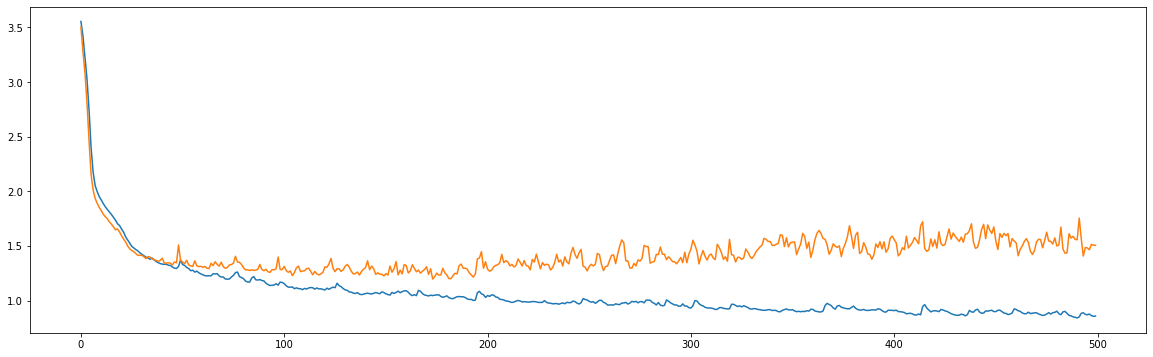

In [37]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [38]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.7400225903614458

In [39]:
from sklearn.mixture import GaussianMixture

train_encoded = encoder(X_train).numpy()

In [40]:
gm1 = GaussianMixture(n_components=5)
gm1.fit(train_encoded.reshape(num_train, -1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [41]:
samples1 = gm1.sample(10)

samples1[0]

array([[-4.05254142e-04, -1.70365741e-04, -7.58894140e-04, ...,
         1.25333758e-03, -3.10436016e-04, -1.59412790e-03],
       [-1.35502379e-03, -1.00840141e-03, -1.02318880e-03, ...,
         2.21981226e-04, -3.20182683e-04, -3.32721274e-04],
       [-9.95091429e-04, -7.41532552e-04,  1.47901750e-03, ...,
         9.93696292e-04, -6.23814117e-04,  1.40598795e-03],
       ...,
       [-1.08429618e-04, -7.84151299e-04,  1.25248261e-03, ...,
         5.70556324e-05,  8.79685789e-04, -1.70532133e-04],
       [-1.12822379e-03, -4.50891942e-04,  4.94189969e-04, ...,
        -8.45436249e-04, -3.35969370e-04, -1.84295886e-04],
       [ 6.99454991e-04,  2.23951249e-04, -6.03408578e-04, ...,
        -5.31093158e-04, -4.63997718e-04, -1.00008209e-03]])

In [43]:
trials = samples1[0].reshape(10, 16, 512)

In [46]:
preds = decoder(trials).numpy().argmax(-1)

In [48]:
preds = replace_with_dict(preds, v2n_mapping)

In [53]:
pd.DataFrame(preds).to_csv("FirstOut.csv", index=False)

In [71]:
pd.read_csv("FirstOut.csv")

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,100,100,100,100,0,100,19,100,0,...,100,19,100,24,19,100,0,100,0,19
1,0,0,100,24,100,19,0,24,24,19,...,0,19,0,24,0,0,0,100,100,24
2,0,24,0,0,0,100,100,24,100,0,...,0,19,0,0,19,100,0,0,100,24
3,0,100,100,100,100,100,0,100,100,100,...,100,100,100,100,100,100,100,100,100,0
4,0,100,100,100,100,100,100,100,100,100,...,0,0,24,0,19,0,100,100,100,19
5,0,19,100,24,0,100,100,0,0,0,...,100,24,100,24,0,0,24,0,100,100
6,0,0,0,100,100,100,0,100,0,0,...,100,100,24,24,100,24,100,0,19,100
7,0,0,100,19,100,0,24,100,19,24,...,19,0,19,24,19,24,19,0,100,19
8,0,100,19,100,0,0,19,0,100,19,...,100,100,19,0,0,24,100,0,100,19
9,0,100,100,0,100,100,0,100,0,0,...,19,0,0,0,100,0,0,100,0,0


## Model 5

In [55]:
X_train, X_test, y_train, y_test = train_test_split(minor_data, minor_data, test_size=0.1, random_state=42)

In [56]:
num_train = X_train.shape[0]

num_test = X_test.shape[0]

In [57]:
timesteps = 64

n2v_mapping['<bon/>'] = 36
v2n_mapping = {value:key for key, value in n2v_mapping.items()}
vocab_size = len(n2v_mapping)

encoder_inputs_training = X_train
decoder_inputs_training = np.ones((num_train, timesteps))
decoder_inputs_training[:,0] *= n2v_mapping['<bon/>']
decoder_inputs_training[:,1:] = X_train[:,:-1]
#decoder_outputs_training = np.ones((num_train, timesteps))
#decoder_outputs_training[:,-1] *= n2v_mapping['<bon/>']
#decoder_outputs_training[:,:-1] = X_train
#decoder_outputs_training = one_hot_encode(decoder_outputs_training, vocab_size)
decoder_outputs_training = one_hot_encode(X_train, vocab_size)

encoder_inputs_testing = X_test
decoder_inputs_testing = np.ones((num_test, timesteps))
decoder_inputs_testing[:,0] *= n2v_mapping['<bon/>']
decoder_inputs_testing[:,1:] = X_test[:,:-1]
#decoder_outputs_testing = np.ones((num_test, timesteps))
#decoder_outputs_testing[:,-1] *= n2v_mapping['<bon/>']
#decoder_outputs_testing[:,:-1] = X_test[:,1:]
#decoder_outputs_testing = one_hot_encode(decoder_outputs_testing, vocab_size)
decoder_outputs_testing = one_hot_encode(X_test, vocab_size)

In [58]:
decoder_outputs_training.shape

(187, 64, 37)

In [59]:
embed_size = 32
latent_dim = 256
dropout = 0.

encoder_inputs = Input(shape=(timesteps,))
embedding = Embedding(vocab_size, embed_size)
encoder_embedding_outputs = embedding(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True, dropout=dropout)
encoder_outputs, state_h, state_c = encoder(encoder_embedding_outputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(timesteps,))
decoder_embedding_outputs = embedding(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_outputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [60]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 64, 32)       1184        input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 295936      embedding_3[0][0]          

In [61]:
batch_size = 32
epochs = 100
lr = 5e-3

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, mode='min')
mc = ModelCheckpoint('NBG_lm_gru.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

model.compile(optimizer, loss='categorical_crossentropy')
hist = model.fit([encoder_inputs_training, decoder_inputs_training], decoder_outputs_training,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([encoder_inputs_testing, decoder_inputs_testing], decoder_outputs_testing),
                 callbacks=[mc]
                )

Epoch 1/100
6/6 [==============================] - 4s 203ms/step - loss: 3.1712 - val_loss: 2.0795
Epoch 2/100
6/6 [==============================] - 0s 37ms/step - loss: 2.0153 - val_loss: 2.0324
Epoch 3/100
6/6 [==============================] - 0s 32ms/step - loss: 2.0038 - val_loss: 2.0293
Epoch 4/100
6/6 [==============================] - 0s 33ms/step - loss: 1.9415 - val_loss: 2.0231
Epoch 5/100
6/6 [==============================] - 0s 32ms/step - loss: 1.9302 - val_loss: 2.0167
Epoch 6/100
6/6 [==============================] - 0s 38ms/step - loss: 1.9485 - val_loss: 2.0010
Epoch 7/100
6/6 [==============================] - 0s 33ms/step - loss: 1.9275 - val_loss: 1.9907
Epoch 8/100
6/6 [==============================] - 0s 33ms/step - loss: 1.8901 - val_loss: 1.9806
Epoch 9/100
6/6 [==============================] - 0s 36ms/step - loss: 1.8731 - val_loss: 1.9763
Epoch 10/100
6/6 [==============================] - 0s 38ms/step - loss: 1.8555 - val_loss: 1.9527
Epoch 11/100
6/6 [

Epoch 84/100
6/6 [==============================] - 0s 36ms/step - loss: 0.5384 - val_loss: 2.1431
Epoch 85/100
6/6 [==============================] - 0s 33ms/step - loss: 0.4996 - val_loss: 2.1718
Epoch 86/100
6/6 [==============================] - 0s 33ms/step - loss: 0.4574 - val_loss: 2.2366
Epoch 87/100
6/6 [==============================] - 0s 35ms/step - loss: 0.4359 - val_loss: 2.2461
Epoch 88/100
6/6 [==============================] - 0s 35ms/step - loss: 0.4100 - val_loss: 2.2980
Epoch 89/100
6/6 [==============================] - 0s 34ms/step - loss: 0.3843 - val_loss: 2.3604
Epoch 90/100
6/6 [==============================] - 0s 34ms/step - loss: 0.3714 - val_loss: 2.3132
Epoch 91/100
6/6 [==============================] - 1s 279ms/step - loss: 0.3759 - val_loss: 2.3402
Epoch 92/100
6/6 [==============================] - 0s 43ms/step - loss: 0.3771 - val_loss: 2.4177
Epoch 93/100
6/6 [==============================] - 0s 38ms/step - loss: 0.3669 - val_loss: 2.4050
Epoch 94/

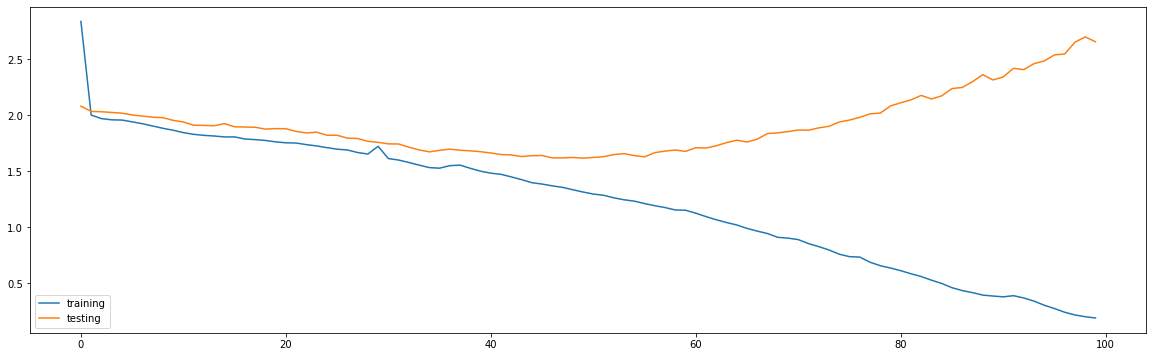

In [62]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

In [63]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_outputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [64]:
encoder_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 64, 32)            1184      
_________________________________________________________________
lstm_2 (LSTM)                [(None, 256), (None, 256) 295936    
Total params: 297,120
Trainable params: 297,120
Non-trainable params: 0
_________________________________________________________________


In [65]:
decoder_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 64, 32)       1184        input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 256)]        0                                            
___________________________________________________________________________________________

In [66]:
results = np.zeros((num_test, timesteps))
test_encoded = encoder_model.predict(encoder_inputs_testing[:,:,np.newaxis])
test_inputs = np.ones((num_test, timesteps + 1)) * n2v_mapping['<bon/>']
for i in range(timesteps):
    decoded_results = decoder_model.predict([test_inputs[:,i+1].reshape(-1, 1)] + test_encoded)
    test_encoded = decoded_results[1:]
    #preds = decoded_results[0].argmax(-1)
    test_inputs[:,i+1] = decoded_results[0].argmax(-1).reshape(-1)

In [67]:
accuracy_score(encoder_inputs_testing.reshape(-1), test_inputs[:,1:].reshape(-1))

0.3787202380952381